In [298]:
# !pip install pytorchvideo transformers evaluate -q
# !pip install accelerate -U
# !pip install torchvision==0.16.0
# !pip install pytorchvideo
# !pip install ipywidgets


In [299]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [300]:
import pathlib
import os

# Define the root path
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)

# Get the folder names (surf classes)
surf_classes = [item.name for item in dataset_root_path.glob("*") if item.is_dir()]

# List to store all mp4 files
full_dataset = []

# Iterate over surf classes and aggregate mp4 files
for surf_class in surf_classes:
    print(surf_class)
    surf_class_path = dataset_root_path / surf_class
    mp4_files = surf_class_path.glob("**/*.mp4")
    full_dataset.extend(mp4_files)
    print('\n'*3)

# Convert to list for easy access if needed
full_dataset = list(full_dataset)

display(full_dataset)


test




train




val






[WindowsPath('data-split/test/360/360.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 1033.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 1165.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 1263.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 1293.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 518.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 529.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 651.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 741.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 742.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 746.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 772.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 851.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 871.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 889.mp4'),
 WindowsPath('data-split/test/360/Séquence imbriquée 89

In [301]:
import os
import torch
import random
import pathlib
import shutil

def split_data(dataset, random_seed=42):
    random.seed(random_seed)
    torch.manual_seed(random_seed)

    train_size = int(0.7 * len(dataset))
    test_size = int(0.2 * len(dataset))
    val_size = len(dataset) - train_size - test_size

    train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size], generator=torch.Generator().manual_seed(random_seed))
    val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

    return train_dataset, val_dataset, test_dataset

# Define the root path
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)

# Iterate over surf classes
for surf_class in surf_classes:
    if surf_class not in ['train', 'val', 'test']:
        surf_class_path = dataset_root_path / surf_class
        mp4_files = list(surf_class_path.glob("**/*.mp4"))

        # Create directories for train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join('data-split', split, surf_class), exist_ok=True)

        # Call the function to split the data
        train_dataset, val_dataset, test_dataset = split_data(mp4_files)

        # Move files to respective directories
        for dataset, split in zip([train_dataset, val_dataset, test_dataset], ['train', 'val', 'test']):
            for file_path in dataset:
                shutil.move(file_path, os.path.join('data-split', split, surf_class, os.path.basename(file_path)))

for item in dataset_root_path.iterdir():
    if item.is_dir() and item.name not in ['train', 'val', 'test']:
        shutil.rmtree(item)

In [302]:
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}
print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['360', 'cutback-frontside', 'roller', 'take-off'].


In [303]:
from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip, Resize
from pytorchvideo.transforms import UniformTemporalSubsample, Normalize, RandomShortSideScale, ApplyTransformToKey
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import torch
import os
import pathlib

video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")


Total videos: 1062


In [304]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification,VideoMAEConfig

# Create a new configuration with the desired image size
# config = VideoMAEConfig(
#     # image_size=(640, 360)
#     image_size=(360, 360)
# )

# Now, use this configuration when initializing your model
model_ckpt = "MCG-NJU/videomae-base"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)



c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [305]:
# Set Training Configuration
args = TrainingArguments(
    "fine-tuned-model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)


In [306]:
# Define Evaluation Metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=1)
    references = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=references)

# Define Collate Function
def collate_fn(examples):
    pixel_values = torch.stack([example["video"].permute(1, 0, 2, 3) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [307]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 16
# sample_rate = 32
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transfor mations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=256, max_size=320),
                    # RandomCrop(resize_to),
                    # RandomHorizontalFlip(p=0.5),
                    Resize((224, 224)),  # Resize images to 224x224

                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # Resize(resize_to),
                    Resize((224, 224)),  # Resize images to 224x224

                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [308]:
# # Initialize a counter
# dataset_size = 0

# # Iterate through the dataset and count the number of samples
# for _ in train_dataset:
#     dataset_size += 1

# print("Training dataset size:", dataset_size)


In [309]:
clip_duration

8.533333333333333

In [310]:
tot = train_dataset.num_videos + val_dataset.num_videos + test_dataset.num_videos
train = train_dataset.num_videos/tot*100
val =val_dataset.num_videos/tot*100
test =test_dataset.num_videos/tot*100

print(f'tot:{tot}')
print(f'train: {train:.2f}%\n')
print(f'test: {test:.2f}%\n')
print(f'val: {val:.2f}%\n')


tot:1062
train: 69.77%

test: 19.87%

val: 10.36%



In [311]:
# # Create an iterator for the dataset
# train_iterator = iter(train_dataset)
# for _ in range(9):
#     next(train_iterator)
# tenth_video = next(train_iterator)
# tenth_video

In [312]:
sample_video = next(iter(train_dataset))
# print(sample_video)
sample_video.keys()

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [362]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        # print(k)
        if k == "video":
            # print(k, sample_video["video"].shape)
            continue
        else:
            # print(k, sample_video[k])
            continue

    print(f"Video label: {id2label[sample_video[k]]}\n")


# investigate_video(sample_video)
# train_iterator = iter(train_dataset)
# sample_videos = [next(train_iterator) for _ in range(3)]
# for sample_video in sample_videos:
#     # investigate_video(sample_video)
#     pass

In [314]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 4}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [315]:
# all_video_file_paths

In [316]:
sample_video.keys()
sample_video['video_name']

'Séquence_imbriquée_280.mp4'

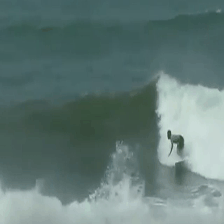

In [378]:
video_tensor = sample_video
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [318]:
model_ckpt.split("/")[-1]
model_ckpt


'MCG-NJU/videomae-base'

In [319]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-2"
num_epochs = 3
batch_size = 4


args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [320]:
import evaluate

metric = evaluate.load("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [321]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [322]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [323]:
train_results = trainer.train()

  0%|          | 0/555 [00:00<?, ?it/s]

{'loss': 1.3861, 'grad_norm': 9.139641761779785, 'learning_rate': 8.92857142857143e-06, 'epoch': 0.02}
{'loss': 1.2321, 'grad_norm': 8.826565742492676, 'learning_rate': 1.785714285714286e-05, 'epoch': 0.04}
{'loss': 1.243, 'grad_norm': 6.707639217376709, 'learning_rate': 2.6785714285714288e-05, 'epoch': 0.05}
{'loss': 1.1312, 'grad_norm': 11.348919868469238, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.07}
{'loss': 1.3058, 'grad_norm': 14.494072914123535, 'learning_rate': 4.464285714285715e-05, 'epoch': 0.09}
{'loss': 1.2019, 'grad_norm': 7.667250156402588, 'learning_rate': 4.9599198396793586e-05, 'epoch': 0.11}
{'loss': 1.2813, 'grad_norm': 8.06010627746582, 'learning_rate': 4.859719438877756e-05, 'epoch': 0.13}
{'loss': 1.2292, 'grad_norm': 10.494473457336426, 'learning_rate': 4.7595190380761524e-05, 'epoch': 0.14}
{'loss': 1.2424, 'grad_norm': 11.735258102416992, 'learning_rate': 4.6593186372745496e-05, 'epoch': 0.16}
{'loss': 1.2314, 'grad_norm': 7.723865509033203, 'learning_

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.9448, 'grad_norm': 12.168312072753906, 'learning_rate': 3.657314629258517e-05, 'epoch': 1.01}
{'loss': 1.1193, 'grad_norm': 7.322641849517822, 'learning_rate': 3.5571142284569145e-05, 'epoch': 1.03}
{'loss': 0.8378, 'grad_norm': 12.514275550842285, 'learning_rate': 3.456913827655311e-05, 'epoch': 1.04}
{'loss': 0.7454, 'grad_norm': 7.457886695861816, 'learning_rate': 3.356713426853708e-05, 'epoch': 1.06}
{'loss': 0.8304, 'grad_norm': 11.546749114990234, 'learning_rate': 3.256513026052104e-05, 'epoch': 1.08}
{'loss': 1.0602, 'grad_norm': 10.54076099395752, 'learning_rate': 3.156312625250501e-05, 'epoch': 1.1}
{'loss': 0.806, 'grad_norm': 31.803747177124023, 'learning_rate': 3.0561122244488974e-05, 'epoch': 1.12}
{'loss': 0.8338, 'grad_norm': 28.31694793701172, 'learning_rate': 2.955911823647295e-05, 'epoch': 1.13}
{'loss': 0.8696, 'grad_norm': 9.744572639465332, 'learning_rate': 2.8557114228456915e-05, 'epoch': 1.15}
{'loss': 0.7245, 'grad_norm': 12.256711959838867, 'learning

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.3997, 'grad_norm': 15.273543357849121, 'learning_rate': 1.7535070140280564e-05, 'epoch': 2.01}
{'loss': 0.2966, 'grad_norm': 9.675086975097656, 'learning_rate': 1.653306613226453e-05, 'epoch': 2.03}
{'loss': 0.3275, 'grad_norm': 0.6464720368385315, 'learning_rate': 1.5531062124248495e-05, 'epoch': 2.05}
{'loss': 0.1516, 'grad_norm': 5.569362163543701, 'learning_rate': 1.4529058116232466e-05, 'epoch': 2.07}
{'loss': 0.5888, 'grad_norm': 20.961273193359375, 'learning_rate': 1.3527054108216433e-05, 'epoch': 2.09}
{'loss': 0.4586, 'grad_norm': 27.309669494628906, 'learning_rate': 1.25250501002004e-05, 'epoch': 2.1}
{'loss': 0.3667, 'grad_norm': 2.0433521270751953, 'learning_rate': 1.152304609218437e-05, 'epoch': 2.12}
{'loss': 0.2505, 'grad_norm': 0.46590688824653625, 'learning_rate': 1.0521042084168337e-05, 'epoch': 2.14}
{'loss': 0.2555, 'grad_norm': 0.8750420808792114, 'learning_rate': 9.519038076152304e-06, 'epoch': 2.16}
{'loss': 0.2616, 'grad_norm': 0.5527063608169556, 'le

In [324]:
trainer.evaluate(train_dataset)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 0.15456415712833405,
 'eval_accuracy': 0.9487179487179487,
 'eval_runtime': 1766.8377,
 'eval_samples_per_second': 0.419,
 'eval_steps_per_second': 0.105,
 'epoch': 2.32972972972973}

In [325]:
trainer.evaluate(test_dataset)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 0.54169100522995,
 'eval_accuracy': 0.8530805687203792,
 'eval_runtime': 505.2243,
 'eval_samples_per_second': 0.418,
 'eval_steps_per_second': 0.105,
 'epoch': 2.32972972972973}

In [326]:
trainer.evaluate(val_dataset)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 0.5939798355102539,
 'eval_accuracy': 0.8636363636363636,
 'eval_runtime': 272.8909,
 'eval_samples_per_second': 0.403,
 'eval_steps_per_second': 0.103,
 'epoch': 2.32972972972973}

In [327]:
train_results

TrainOutput(global_step=555, training_loss=0.7599288858808912, metrics={'train_runtime': 12937.383, 'train_samples_per_second': 0.172, 'train_steps_per_second': 0.043, 'total_flos': 2.758836207590572e+18, 'train_loss': 0.7599288858808912, 'epoch': 2.32972972972973})

In [328]:
train_loss = train_results.training_loss

val_results = trainer.evaluate(eval_dataset=val_dataset)
val_loss = val_results['eval_loss']

# Calculate the ratio
loss_ratio = val_loss / train_loss

# Print the ratio
print("Validation Loss / Training Loss Ratio:", loss_ratio)


c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation Loss / Training Loss Ratio: 0.7816253959243007


In [329]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

events.out.tfevents.1715919261.MSI.2780.1:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


***** test metrics *****
  epoch                   =     2.3297
  eval_accuracy           =     0.8531
  eval_loss               =     0.5417
  eval_runtime            = 0:08:30.47
  eval_samples_per_second =      0.413
  eval_steps_per_second   =      0.104


In [330]:
# trainer.push_to_hub()

In [349]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [413]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)
logits = run_inference(trained_model, sample_test_video["video"])


Video label: 360



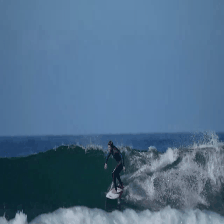

In [414]:
display_gif(sample_test_video["video"])


In [415]:
print(logits)
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


tensor([[ 4.0709, -1.6554, -1.4962, -2.5557]])
Predicted class: 360


In [416]:
print(model.config.id2label)

{0: '360', 1: 'cutback-frontside', 2: 'roller', 3: 'take-off'}
